In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from raptor_utils import *
import networkx as nx

In [149]:
file_path = '/Users/theomacmillan/Downloads/google_transit_20250113-20250808_v03'
stop_times_df = pd.read_csv(file_path + '/stop_times.txt')
transfers_df = pd.read_csv(file_path + '/transfers.txt')
stops_df = pd.read_csv(file_path + '/stops.txt')

# if min_transfer_time is NaN, set to 0
transfers_df['min_transfer_time'] = transfers_df['min_transfer_time'].fillna(0)

In [150]:
class Subway:
    def __init__(self, stop_times_df, stops_df, transfers_df):
        self.unique_stop_ids = set([stop[:3] for stop in stops_df.stop_id])
        self.time_table = stop_times_df.copy()
        self.stops_df = stops_df.copy()
        self.transfers_df = transfers_df.copy()

        ## prune time table a little bit
        # self.time_table['stop_id'] = self.time_table['stop_id'].apply(lambda x: x[:3])

        # if arrival time has time greater than 23:00, mod it by 24 hours in string form
        self.time_table['arrival_time'] = self.time_table['arrival_time'].apply(lambda x: x if int(x[:2]) < 24 else str(int(x[:2]) % 24) + x[2:])
        self.time_table['departure_time'] = self.time_table['departure_time'].apply(lambda x: x if int(x[:2]) < 24 else str(int(x[:2]) % 24) + x[2:])

        self.time_table['arrival_time'] = pd.to_datetime(self.time_table['arrival_time'])
        self.time_table['departure_time'] = pd.to_datetime(self.time_table['departure_time'])
        
        self.stop_id_to_index = {stop_id: i for i, stop_id in enumerate(self.unique_stop_ids)}

    def generate_links(self):
        # generates a link between two station whenever you can take a train from one to the other and stores the result in a dataframe
        # the 'weight' is a timedelta object of how long it takes to travel between the two
        #self.link_df = pd.DataFrame(columns=['departing_station', 'arriving_station', 'travel_time'])
        self.links = {}
        
        # trains between stations
        for i,row in self.time_table.iterrows():
            if i == 0:
                continue
            if self.time_table.loc[i-1, 'trip_id'] == row['trip_id']:
                if self.time_table.loc[i-1, 'stop_id'] != row['stop_id']:
                    # we are at the same trip and we are at different stops
                    # we can add a link between the two
                    # append link to link_df
                    self.links[(self.time_table.loc[i-1, 'stop_id'], row['stop_id'])] = (row['arrival_time'] - self.time_table.loc[i-1, 'departure_time']).seconds
                    self.links[(row['stop_id'], self.time_table.loc[i-1, 'stop_id'])] = (row['arrival_time'] - self.time_table.loc[i-1, 'departure_time']).seconds
        
        #transfers between stations
        for i,row in self.transfers_df.iterrows():
            if row['from_stop_id'] in self.unique_stop_ids and row['to_stop_id'] in self.unique_stop_ids:
                self.links[(row['from_stop_id'], row['to_stop_id'])] = int(row['min_transfer_time'])
                self.links[(row['to_stop_id'], row['from_stop_id'])] = int(row['min_transfer_time'])


        self.links_df = pd.DataFrame(subway.links.items(), columns=['station_pair', 'travel_time'])

        return
    
    def generate_graph(self):
        G = nx.Graph()
        
        # get the MINIMUM travel time between two stations
        self.links_df = self.links_df.groupby('station_pair').travel_time.min().reset_index()

        for i, row in subway.links_df.iterrows():
            G.add_edge(row['station_pair'][0], row['station_pair'][1], weight=row['travel_time'])

        for node in G.nodes:
            row = stops_df[self.stops_df.stop_id == node]
            G.nodes[node]['pos'] = (row.stop_lon.values[0], row.stop_lat.values[0])

        self.graph = G
    
        # remove self edges
        self.graph.remove_edges_from([(u, v) for u, v in self.graph.edges() if u == v])

        return

subway = Subway(stop_times_df, stops_df, transfers_df)
subway.generate_links()
subway.generate_graph()

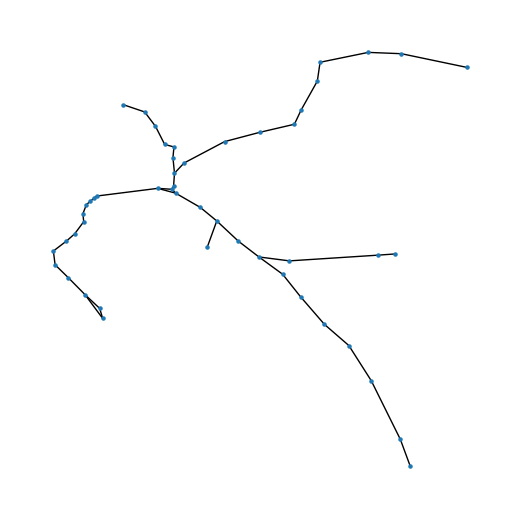

In [151]:
# Retrieve updated positions from the graph
pos = nx.get_node_attributes(subway.graph, 'pos')

plt.figure(figsize=(5, 5))
nx.draw(subway.graph, pos, with_labels=False, node_size=5, font_size=10, font_color="blue")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [152]:
subway.graph.nodes()

NodeView(('12TH', '19TH', 'LAKE', 'WOAK', '16TH', '24TH', 'CIVC', 'MCAR', 'GLEN', 'ANTC', 'PCTR', 'ASHB', 'DBRK', 'BALB', 'DALY', 'BAYF', 'CAST', 'HAYW', 'SANL', 'BERY', 'MLPT', 'WDUB', 'POWL', 'COLM', 'SSAN', 'COLS', 'FTVL', 'OAKL', 'CONC', 'NCON', 'PHIL', 'NBRK', 'DELN', 'PLZA', 'RICH', 'DUBL', 'EMBR', 'MONT', 'FRMT', 'UCTY', 'WARM', 'SHAY', 'LAFY', 'ORIN', 'WCRK', 'ROCK', 'MLBR', 'SBRN', 'SFIA', 'PITT'))

In [153]:
travel_times = dict(nx.all_pairs_dijkstra_path_length(subway.graph))

In [155]:
def solve_tsp(starting_station, G):
    def create_data_model():
        """Stores the data for the problem."""
        data = {}

        node_list = list(G.nodes)
        all_to_all_weights = dict(nx.all_pairs_dijkstra_path_length(G))
        cost_dict = all_to_all_weights
        cost_matrix = np.ones((len(cost_dict), len(cost_dict)), dtype=int)*100000

        for key, val in cost_dict.items():
            for k, v in val.items():
                cost_matrix[node_list.index(key), node_list.index(k)] = int(v)

        data["distance_matrix"] = cost_matrix
        data["num_vehicles"] = 1
        data["depot"] = node_list.index(starting_station)
        return data


    def print_solution(manager, routing, solution):
        """Prints solution on console."""
        #print(f"Objective: {solution.ObjectiveValue()/60/60} hours")
        index = routing.Start(0)
        #plan_output = "Route for vehicle 0:\n"
        route_distance = 0
        route = []
        node_list = list(G.nodes)
        while not routing.IsEnd(index):
            #plan_output += f" {node_list[manager.IndexToNode(index)]} ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
            #print(manager.IndexToNode(previous_index))
            route.append(node_list[manager.IndexToNode(previous_index)])
        #plan_output += f" {manager.IndexToNode(index)}\n"
        #print(plan_output)
        #plan_output += f"Route distance: {route_distance}miles\n"
        return route, solution.ObjectiveValue()/60/60


    def main():
        """Entry point of the program."""
        # Instantiate the data problem.
        data = create_data_model()

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(
            len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
        )

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)


        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data["distance_matrix"][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        )

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        # Print solution on console.
        if solution:
            route, route_time = print_solution(manager, routing, solution)
            return route, route_time
        
    route, route_time = main()
    return route, route_time

or_routes = {}

for starting_station in subway.graph.nodes():
    or_tools_route, or_tools_route_time = solve_tsp(starting_station, subway.graph)
    route_time = 0

    or_routes[starting_station] = or_tools_route

    for i, station in enumerate(or_tools_route[1:]):
        previous_station = or_tools_route[i]

        route_time += travel_times[previous_station][station]

    print(starting_station, route_time/60/60)

12TH 5.5
19TH 5.766666666666667
LAKE 5.833333333333333
WOAK 5.566666666666666
16TH 5.55
24TH 5.783333333333333
CIVC 5.583333333333333
MCAR 5.433333333333334
GLEN 5.5
ANTC 4.633333333333334
PCTR 4.75
ASHB 5.383333333333334
DBRK 5.35
BALB 5.85
DALY 5.416666666666667
BAYF 5.816666666666666
CAST 5.883333333333334
HAYW 5.6
SANL 5.883333333333334
BERY 5.266666666666667
MLPT 5.333333333333333
WDUB 5.6
POWL 5.6
COLM 5.933333333333334
SSAN 5.333333333333333
COLS 5.95
FTVL 5.9
OAKL 5.533333333333333
CONC 5.033333333333333
NCON 5.75
PHIL 5.616666666666666
NBRK 5.933333333333334
DELN 6.033333333333333
PLZA 5.266666666666667
RICH 5.15
DUBL 5.533333333333333
EMBR 5.633333333333334
MONT 5.616666666666666
FRMT 5.816666666666666
UCTY 5.616666666666666
WARM 5.916666666666667
SHAY 5.666666666666667
LAFY 5.216666666666667
ORIN 5.433333333333334
WCRK 5.15
ROCK 5.35
MLBR 5.216666666666667
SBRN 6.033333333333333
SFIA 6.033333333333333
PITT 5.85


In [110]:
route_time = 0

for i, station in enumerate(or_tools_route[1:]):
    previous_station = or_tools_route[i]

    route_time += travel_times[previous_station][station]

print(route_time/60/60)

5.15


In [133]:
%%time
# Define your source and target stops and a desired departure time.
source_stop = "ANTC"      # Replace with an actual stop_id from your GTFS data
target_stop = "BERY"      # Replace with an actual stop_id from your GTFS data
departure_time_str = "08:00:00"  # The desired departure time

# Find the fastest route.
path, total_time = find_fastest_route(graph, events, topo_order, source_stop, departure_time_str, target_stop)

if path:
    print("Fastest route found (total travel time in seconds):", total_time)
    print("Route (list of event IDs with details):")
    for event_id in path:
        event = events[event_id]
        print(f"  {event_id}: Stop {event['stop_id']} at time {event['time']} ({event['type']})")
else:
    print("No route could be found.")

Fastest route found (total travel time in seconds): 6960
Route (list of event IDs with details):
  dep_1674400_28: Stop ANTC at time 29280 (departure)
  dep_1682611_27: Stop ANTC at time 29280 (departure)
  arr_1674232_0: Stop ANTC at time 29400 (arrival)
  dep_1674232_0: Stop ANTC at time 29400 (departure)
  arr_1674232_1: Stop PCTR at time 29820 (arrival)
  dep_1674232_1: Stop PCTR at time 29820 (departure)
  arr_1674232_2: Stop PITT at time 30240 (arrival)
  dep_1674232_2: Stop PITT at time 30240 (departure)
  arr_1674232_3: Stop NCON at time 30600 (arrival)
  dep_1674232_3: Stop NCON at time 30660 (departure)
  arr_1674232_4: Stop CONC at time 30840 (arrival)
  dep_1674232_4: Stop CONC at time 30900 (departure)
  arr_1674232_5: Stop PHIL at time 31140 (arrival)
  dep_1674232_5: Stop PHIL at time 31200 (departure)
  arr_1674232_6: Stop WCRK at time 31320 (arrival)
  dep_1674232_6: Stop WCRK at time 31380 (departure)
  arr_1674232_7: Stop LAFY at time 31620 (arrival)
  dep_1674232_7:

In [119]:
subway.graph.nodes()

NodeView(('12TH', '19TH', 'LAKE', 'WOAK', '16TH', '24TH', 'CIVC', 'MCAR', 'GLEN', 'ANTC', 'PCTR', 'ASHB', 'DBRK', 'BALB', 'DALY', 'BAYF', 'CAST', 'HAYW', 'SANL', 'BERY', 'MLPT', 'WDUB', 'POWL', 'COLM', 'SSAN', 'COLS', 'FTVL', 'OAKL', 'CONC', 'NCON', 'PHIL', 'NBRK', 'DELN', 'PLZA', 'RICH', 'DUBL', 'EMBR', 'MONT', 'FRMT', 'UCTY', 'WARM', 'SHAY', 'LAFY', 'ORIN', 'WCRK', 'ROCK', 'MLBR', 'SBRN', 'SFIA', 'PITT'))

In [127]:
import pandas as pd
from collections import defaultdict, deque
import math

def parse_time(time_str):
    """
    Convert a GTFS time string (HH:MM:SS) into seconds past midnight.
    GTFS times can exceed 24:00:00, so we simply convert hours, minutes, seconds.
    """
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

def build_time_expanded_graph(stop_times_file):
    """
    Build a time expanded graph from a GTFS stop_times.txt file.
    
    For each row in stop_times:
      - Create two nodes: an arrival event and a departure event.
      - Add a "dwell" edge from the arrival to the departure (the waiting time on board).
    
    Then add:
      - "Ride" edges: For each trip, connect the departure event of one stop 
        to the arrival event of the next stop (the in-vehicle travel time).
      - "Waiting" edges: For each stop (regardless of trip), link consecutive events 
        (allowing transfers/waiting) by time order.
    
    Returns:
      graph: dict mapping event_id -> list of (neighbor_event_id, weight, edge_type)
      events: dict mapping event_id -> event details (with keys: stop_id, time, type, trip_id, stop_sequence)
    """
    df = pd.read_csv(stop_times_file)
    
    graph = defaultdict(list)
    events = {}
    
    # Create nodes (events) for each stop time row.
    for idx, row in df.iterrows():
        trip_id = row['trip_id']
        stop_id = row['stop_id']
        stop_seq = row['stop_sequence']
        arr_time = parse_time(row['arrival_time'])
        dep_time = parse_time(row['departure_time'])
        
        # Unique IDs for arrival and departure events
        arr_event_id = f"arr_{trip_id}_{stop_seq}"
        dep_event_id = f"dep_{trip_id}_{stop_seq}"
        
        # Record the events
        events[arr_event_id] = {
            'stop_id': stop_id,
            'time': arr_time,
            'type': 'arrival',
            'trip_id': trip_id,
            'stop_sequence': stop_seq
        }
        events[dep_event_id] = {
            'stop_id': stop_id,
            'time': dep_time,
            'type': 'departure',
            'trip_id': trip_id,
            'stop_sequence': stop_seq
        }
        
        # Add dwell edge: from arrival to departure at the same stop.
        dwell_weight = max(dep_time - arr_time, 0)
        graph[arr_event_id].append((dep_event_id, dwell_weight, 'dwell'))
    
    # Add ride edges: within each trip, connect departure from one stop to arrival at the next stop.
    trips = df.groupby('trip_id')
    for trip_id, group in trips:
        group_sorted = group.sort_values('stop_sequence')
        previous_row = None
        for idx, row in group_sorted.iterrows():
            if previous_row is not None:
                prev_dep_event = f"dep_{previous_row['trip_id']}_{previous_row['stop_sequence']}"
                curr_arr_event = f"arr_{row['trip_id']}_{row['stop_sequence']}"
                prev_dep_time = parse_time(previous_row['departure_time'])
                curr_arr_time = parse_time(row['arrival_time'])
                travel_weight = max(curr_arr_time - prev_dep_time, 0)
                graph[prev_dep_event].append((curr_arr_event, travel_weight, 'ride'))
            previous_row = row
    
    # Add waiting edges: allow transferring by waiting at the same stop.
    # For each stop, sort all events by time and add an edge from each event to the next.
    stops = defaultdict(list)
    for event_id, data in events.items():
        stops[data['stop_id']].append((data['time'], event_id))
    
    for stop_id, time_events in stops.items():
        time_events.sort()  # sort by event time
        for i in range(len(time_events) - 1):
            time_current, event_current = time_events[i]
            time_next, event_next = time_events[i+1]
            wait_time = time_next - time_current
            if wait_time >= 0:
                graph[event_current].append((event_next, wait_time, 'wait'))
    
    return graph, events

def topological_sort(graph, events):
    """
    Perform a topological sort on the DAG.
    Returns a list of event IDs in topologically sorted order.
    """
    in_degree = {event_id: 0 for event_id in events}
    for u in graph:
        for v, weight, edge_type in graph[u]:
            in_degree[v] += 1

    queue = deque([node for node, deg in in_degree.items() if deg == 0])
    topo_order = []
    
    while queue:
        u = queue.popleft()
        topo_order.append(u)
        for v, weight, edge_type in graph[u]:
            in_degree[v] -= 1
            if in_degree[v] == 0:
                queue.append(v)
                
    if len(topo_order) != len(events):
        print("Warning: Not all events were sorted. Check for cycles or disconnected parts.")
    return topo_order

def dag_shortest_paths(graph, topo_order, source):
    """
    Compute shortest paths in a DAG using dynamic programming along the topologically sorted order.
    
    Returns:
      dist: dict mapping event_id to distance (in seconds) from the source event.
      pred: dict mapping event_id to its predecessor on the shortest path.
    """
    dist = {node: math.inf for node in topo_order}
    pred = {node: None for node in topo_order}
    dist[source] = 0
    
    for u in topo_order:
        for v, weight, edge_type in graph[u]:
            if dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
                pred[v] = u
    return dist, pred

def reconstruct_path(pred, source, target):
    """
    Reconstruct the path from the source to target using the predecessor map.
    Returns a list of event IDs representing the route.
    """
    path = []
    current = target
    while current is not None:
        path.append(current)
        current = pred[current]
    path.reverse()
    return path if path and path[0] == source else []

def find_fastest_route(graph, events, topo_order, source_stop, departure_time_str, target_stop):
    """
    Find the fastest route from a given source stop (after a desired departure time) to a target stop.
    
    This function:
      1. Selects the earliest departure event at the source stop that is at or after the given time.
      2. Runs the DAG shortest path algorithm.
      3. Chooses the best (earliest arriving) arrival event at the target stop.
    
    Returns the list of event IDs representing the path and the total travel time in seconds.
    """
    departure_time = parse_time(departure_time_str)
    
    # Find candidate departure events at the source stop
    candidate_sources = []
    for event_id, data in events.items():
        if data['stop_id'] == source_stop and data['type'] == 'departure' and data['time'] >= departure_time:
            candidate_sources.append((data['time'], event_id))
    if not candidate_sources:
        print("No departure events available at the source stop after", departure_time_str)
        return None, None
    candidate_sources.sort()
    source_event = candidate_sources[0][1]  # choose the earliest valid departure event
    
    # Compute shortest paths from the chosen source event
    dist, pred = dag_shortest_paths(graph, topo_order, source_event)
    
    # Among arrival events at the target stop, select the one with the shortest travel time
    target_candidates = []
    for event_id, data in events.items():
        if data['stop_id'] == target_stop and data['type'] == 'arrival' and dist[event_id] < math.inf:
            target_candidates.append((dist[event_id], event_id))
    if not target_candidates:
        print("No reachable arrival events found at the target stop.")
        return source_event, None
    target_candidates.sort()
    best_target = target_candidates[0][1]
    best_distance = target_candidates[0][0]
    
    path = reconstruct_path(pred, source_event, best_target)
    return path, best_distance

def find_fastest_routes_to_all_stations(graph, events, topo_order, source_stop, departure_time_str):
    """
    Find the fastest route from the source station to every other station.
    
    Steps:
      1. Identify the earliest departure event at the source station after the given departure time.
      2. Compute shortest paths from that source event using the DAG method.
      3. For each station, select the arrival event with the minimum travel time.
      4. Reconstruct and return the route for each station.
    
    Returns:
      A dictionary mapping each station to a dictionary with keys:
        - 'arrival_event': the best arrival event ID at that station,
        - 'total_travel_time': the travel time (in seconds),
        - 'route': the list of event IDs from source to that arrival.
    """
    departure_time = parse_time(departure_time_str)
    
    # Find candidate departure events at the source stop
    candidate_sources = []
    for event_id, data in events.items():
        if data['stop_id'] == source_stop and data['type'] == 'departure' and data['time'] >= departure_time:
            candidate_sources.append((data['time'], event_id))
    if not candidate_sources:
        print("No departure events available at the source stop after", departure_time_str)
        return None
    candidate_sources.sort()
    source_event = candidate_sources[0][1]
    
    # Compute shortest paths from the chosen source event
    dist, pred = dag_shortest_paths(graph, topo_order, source_event)
    
    # For each station, pick the best arrival event (if reachable)
    best_routes = {}
    for event_id, data in events.items():
        if data['type'] == 'arrival' and dist[event_id] < math.inf:
            stop = data['stop_id']
            if stop not in best_routes or dist[event_id] < best_routes[stop][0]:
                best_routes[stop] = (dist[event_id], event_id)
    
    # Reconstruct the route for each station
    routes = {}
    for stop, (travel_time, arrival_event) in best_routes.items():
        route = reconstruct_path(pred, source_event, arrival_event)
        routes[stop] = {
            'arrival_event': arrival_event,
            'total_travel_time': travel_time,
            'route': route
        }
    return routes

# --- Example usage ---
# if __name__ == "__main__":
# Replace with the actual path to your GTFS stop_times.txt file.
stop_times_file = "/Users/theomacmillan/Downloads/google_transit_20250113-20250808_v03/stop_times.txt"

# Build the time-expanded graph.
graph, events = build_time_expanded_graph(stop_times_file)

# Obtain a topological order of the events.
topo_order = topological_sort(graph, events)

In [130]:
%%time

# Define your source and target stops and a desired departure time.
source_stop = "ANTC"       # Replace with an actual stop_id from your GTFS data
departure_time_str = "08:00:00"  # The desired departure time

# --- Find fastest routes to all stations ---
print("\nFinding fastest routes from", source_stop, "to every station:")
routes_to_all = find_fastest_routes_to_all_stations(graph, events, topo_order, source_stop, departure_time_str)
if routes_to_all:
    for station, route_info in routes_to_all.items():
        print(f"\nStation: {station}")
        print(f"  Arrival Event: {route_info['arrival_event']}")
        print(f"  Total Travel Time (sec): {route_info['total_travel_time']}")
        print("  Route:")
        for event_id in route_info['route']:
            event = events[event_id]
            print(f"    {event_id}: Stop {event['stop_id']} at time {event['time']} ({event['type']})")
else:
    print("No routes found from the source station.")


Finding fastest routes from ANTC to every station:

Station: ANTC
  Arrival Event: arr_1682369_0
  Total Travel Time (sec): 120
  Route:
    dep_1674400_28: Stop ANTC at time 29280 (departure)
    dep_1682611_27: Stop ANTC at time 29280 (departure)
    arr_1674232_0: Stop ANTC at time 29400 (arrival)
    arr_1677393_0: Stop ANTC at time 29400 (arrival)
    arr_1682369_0: Stop ANTC at time 29400 (arrival)

Station: PCTR
  Arrival Event: arr_1682369_1
  Total Travel Time (sec): 540
  Route:
    dep_1674400_28: Stop ANTC at time 29280 (departure)
    dep_1682611_27: Stop ANTC at time 29280 (departure)
    arr_1674232_0: Stop ANTC at time 29400 (arrival)
    dep_1674232_0: Stop ANTC at time 29400 (departure)
    arr_1674232_1: Stop PCTR at time 29820 (arrival)
    arr_1677393_1: Stop PCTR at time 29820 (arrival)
    arr_1682369_1: Stop PCTR at time 29820 (arrival)

Station: PITT
  Arrival Event: arr_1682369_2
  Total Travel Time (sec): 960
  Route:
    dep_1674400_28: Stop ANTC at time 29

### Check feasibility of the found route

In [138]:
import pandas as pd
from collections import defaultdict, deque
import math

def parse_time(time_str):
    """
    Convert a GTFS time string (HH:MM:SS) into seconds past midnight.
    GTFS times can exceed 24:00:00, so we simply convert hours, minutes, seconds.
    """
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

def build_time_expanded_graph(stop_times_file):
    """
    Build a time-expanded graph from a GTFS stop_times.txt file.
    
    For each row:
      - Create two events: an arrival event and a departure event.
      - Add a 'dwell' edge from the arrival to the departure (time spent waiting at the station).
    
    Then add:
      - 'Ride' edges: For each trip, connect departure at one stop to arrival at the next.
      - 'Wait' edges: For each stop, connect consecutive events by time (allowing transfers).
    
    Returns:
      graph: dict mapping event_id -> list of (neighbor_event_id, weight, edge_type)
      events: dict mapping event_id -> event details (stop_id, time, type, trip_id, stop_sequence)
    """
    df = pd.read_csv(stop_times_file)
    graph = defaultdict(list)
    events = {}
    
    # Create nodes (events) for each stop time row.
    for idx, row in df.iterrows():
        trip_id = row['trip_id']
        stop_id = row['stop_id']
        stop_seq = row['stop_sequence']
        arr_time = parse_time(row['arrival_time'])
        dep_time = parse_time(row['departure_time'])
        
        # Unique IDs for arrival and departure events.
        arr_event_id = f"arr_{trip_id}_{stop_seq}"
        dep_event_id = f"dep_{trip_id}_{stop_seq}"
        
        events[arr_event_id] = {
            'stop_id': stop_id,
            'time': arr_time,
            'type': 'arrival',
            'trip_id': trip_id,
            'stop_sequence': stop_seq
        }
        events[dep_event_id] = {
            'stop_id': stop_id,
            'time': dep_time,
            'type': 'departure',
            'trip_id': trip_id,
            'stop_sequence': stop_seq
        }
        
        # Add dwell edge: from arrival to departure.
        dwell_weight = max(dep_time - arr_time, 0)
        graph[arr_event_id].append((dep_event_id, dwell_weight, 'dwell'))
    
    # Add ride edges: within each trip, connect departure at one stop to arrival at the next.
    trips = df.groupby('trip_id')
    for trip_id, group in trips:
        group_sorted = group.sort_values('stop_sequence')
        previous_row = None
        for idx, row in group_sorted.iterrows():
            if previous_row is not None:
                prev_dep_event = f"dep_{previous_row['trip_id']}_{previous_row['stop_sequence']}"
                curr_arr_event = f"arr_{row['trip_id']}_{row['stop_sequence']}"
                prev_dep_time = parse_time(previous_row['departure_time'])
                curr_arr_time = parse_time(row['arrival_time'])
                travel_weight = max(curr_arr_time - prev_dep_time, 0)
                graph[prev_dep_event].append((curr_arr_event, travel_weight, 'ride'))
            previous_row = row
    
    # Add waiting edges: allow transfers by connecting consecutive events at the same stop.
    stops = defaultdict(list)
    for event_id, data in events.items():
        stops[data['stop_id']].append((data['time'], event_id))
    
    for stop_id, time_events in stops.items():
        time_events.sort()  # sort by event time
        for i in range(len(time_events) - 1):
            time_current, event_current = time_events[i]
            time_next, event_next = time_events[i + 1]
            wait_time = time_next - time_current
            if wait_time >= 0:
                graph[event_current].append((event_next, wait_time, 'wait'))
    
    return graph, events

def topological_sort(graph, events):
    """
    Perform a topological sort on the DAG using Kahn's algorithm.
    Returns a list of event IDs in topologically sorted order.
    """
    in_degree = {event_id: 0 for event_id in events}
    for u in graph:
        for v, weight, edge_type in graph[u]:
            in_degree[v] += 1
            
    queue = deque([node for node, deg in in_degree.items() if deg == 0])
    topo_order = []
    
    while queue:
        u = queue.popleft()
        topo_order.append(u)
        for v, weight, edge_type in graph[u]:
            in_degree[v] -= 1
            if in_degree[v] == 0:
                queue.append(v)
    
    if len(topo_order) != len(events):
        print("Warning: Not all events were sorted; check for cycles or disconnected components.")
    return topo_order

def dag_shortest_paths(graph, topo_order, source):
    """
    Compute shortest paths in a DAG using dynamic programming along the topological order.
    Returns:
      dist: dict mapping event_id to distance (in seconds) from the source.
      pred: dict mapping event_id to its predecessor on the shortest path.
    """
    dist = {node: math.inf for node in topo_order}
    pred = {node: None for node in topo_order}
    dist[source] = 0
    
    for u in topo_order:
        for v, weight, edge_type in graph[u]:
            if dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
                pred[v] = u
    return dist, pred

def reconstruct_path(pred, source, target):
    """
    Reconstruct the shortest path from source to target using the predecessor map.
    Returns a list of event IDs representing the path.
    """
    path = []
    current = target
    while current is not None:
        path.append(current)
        current = pred[current]
    path.reverse()
    return path if path and path[0] == source else []

class GTFSGraph:
    def __init__(self, stop_times_file):
        """
        Build the time-expanded graph and compute the topological sort once.
        """
        self.graph, self.events = build_time_expanded_graph(stop_times_file)
        self.topo_order = topological_sort(self.graph, self.events)
    
    def find_fastest_route(self, source_stop, departure_time_sec, destination_stop):
        """
        Find the fastest route from source_stop (departing no earlier than departure_time_sec)
        to destination_stop.
        
        Parameters:
          source_stop: station ID at which to start.
          departure_time_sec: departure time in seconds past midnight.
          destination_stop: station ID to reach.
        
        Returns:
          route: List of event IDs for the route (if found).
          arrival_time_sec: Final arrival time at the destination (in seconds) if route is found,
                            otherwise None.
        """
        # Select candidate departure events at the source stop.
        candidate_sources = []
        for event_id, data in self.events.items():
            if data['stop_id'] == source_stop and data['type'] == 'departure' and data['time'] >= departure_time_sec:
                candidate_sources.append((data['time'], event_id))
        
        if not candidate_sources:
            print(f"No departures available at {source_stop} after {departure_time_sec} seconds.")
            return None, None
        
        candidate_sources.sort()
        source_event = candidate_sources[0][1]
        
        # Compute shortest paths from the chosen source event.
        dist, pred = dag_shortest_paths(self.graph, self.topo_order, source_event)
        
        # Choose the best arrival event at the destination stop.
        target_candidates = []
        for event_id, data in self.events.items():
            if data['stop_id'] == destination_stop and data['type'] == 'arrival' and dist[event_id] < math.inf:
                target_candidates.append((dist[event_id], event_id))
        
        if not target_candidates:
            print(f"No reachable arrival events found at destination {destination_stop}.")
            return None, None
        
        target_candidates.sort()
        best_distance, best_target = target_candidates[0]
        route = reconstruct_path(pred, source_event, best_target)
        
        # The final event's absolute time is the arrival time at the destination.
        arrival_time_sec = self.events[route[-1]]['time'] if route else None
        return route, arrival_time_sec
    
    def get_arrival_time(self, source_stop, destination_stop, departure_time_sec):
        """
        A convenience method that returns only the final arrival time in seconds.
        """
        _, arrival_time_sec = self.find_fastest_route(source_stop, departure_time_sec, destination_stop)
        return arrival_time_sec

# --- Example usage ---
# Replace with the path to your GTFS stop_times.txt file.
stop_times_file = "/Users/theomacmillan/Downloads/google_transit_20250113-20250808_v03/stop_times.txt"


# Build the GTFS graph (graph construction and topological sort happen here once).
gtfs_graph = GTFSGraph(stop_times_file)

In [139]:
# Define some example queries.
# Provide the starting time in seconds (e.g., 08:00:00 is 8*3600 = 28800 seconds).
departure_time_sec = 28800  # 08:00:00 in seconds

# Query 1: From station "STOP1" to station "STOP5".


source_station = "ANTC"         # Replace with a valid stop_id from your GTFS data.
destination_station = "DUBL"      # Replace with a valid stop_id from your GTFS data.
arrival_sec = gtfs_graph.get_arrival_time(source_station, destination_station, departure_time_sec)


If you leave ANTC at or after 28800 seconds,
you will arrive at DUBL at 35280 seconds (past midnight).


In [163]:
# loop through initial starting times
initial_starting_times = [i*0.5 for i in range(14, 36)]

route = or_routes['BERY']

for initial_starting_time in initial_starting_times:
    current_time = initial_starting_time*60*60

    for i in range(len(or_tools_route[1:])):
        starting_station = route[i]
        ending_station = route[i+1]

        current_time = gtfs_graph.get_arrival_time(starting_station, ending_station, current_time)

    print(f'Starting at {initial_starting_time} hours, the route takes {current_time/60/60-initial_starting_time:02f} hours')

Starting at 7.0 hours, the route takes 6.800000 hours
Starting at 7.5 hours, the route takes 6.633333 hours
Starting at 8.0 hours, the route takes 6.800000 hours
Starting at 8.5 hours, the route takes 6.633333 hours
Starting at 9.0 hours, the route takes 6.800000 hours
Starting at 9.5 hours, the route takes 6.633333 hours
Starting at 10.0 hours, the route takes 6.800000 hours
Starting at 10.5 hours, the route takes 6.633333 hours
Starting at 11.0 hours, the route takes 6.800000 hours
Starting at 11.5 hours, the route takes 6.633333 hours
Starting at 12.0 hours, the route takes 6.800000 hours
Starting at 12.5 hours, the route takes 6.633333 hours
Starting at 13.0 hours, the route takes 6.800000 hours
Starting at 13.5 hours, the route takes 6.633333 hours
Starting at 14.0 hours, the route takes 6.916667 hours
Starting at 14.5 hours, the route takes 6.750000 hours
Starting at 15.0 hours, the route takes 6.916667 hours
Starting at 15.5 hours, the route takes 6.750000 hours
Starting at 16.0

In [157]:
subway.graph.nodes()

NodeView(('12TH', '19TH', 'LAKE', 'WOAK', '16TH', '24TH', 'CIVC', 'MCAR', 'GLEN', 'ANTC', 'PCTR', 'ASHB', 'DBRK', 'BALB', 'DALY', 'BAYF', 'CAST', 'HAYW', 'SANL', 'BERY', 'MLPT', 'WDUB', 'POWL', 'COLM', 'SSAN', 'COLS', 'FTVL', 'OAKL', 'CONC', 'NCON', 'PHIL', 'NBRK', 'DELN', 'PLZA', 'RICH', 'DUBL', 'EMBR', 'MONT', 'FRMT', 'UCTY', 'WARM', 'SHAY', 'LAFY', 'ORIN', 'WCRK', 'ROCK', 'MLBR', 'SBRN', 'SFIA', 'PITT'))

In [162]:
or_routes['ANTC']

['ANTC',
 'PCTR',
 'PITT',
 'NCON',
 'CONC',
 'PHIL',
 'WCRK',
 'LAFY',
 'ORIN',
 'ROCK',
 'MCAR',
 'ASHB',
 'DBRK',
 'NBRK',
 'PLZA',
 'DELN',
 'RICH',
 '19TH',
 '12TH',
 'LAKE',
 'FTVL',
 'COLS',
 'SANL',
 'BAYF',
 'HAYW',
 'SHAY',
 'UCTY',
 'FRMT',
 'WARM',
 'MLPT',
 'BERY',
 'CAST',
 'WDUB',
 'DUBL',
 'OAKL',
 'WOAK',
 'EMBR',
 'MONT',
 'POWL',
 'CIVC',
 '16TH',
 '24TH',
 'GLEN',
 'BALB',
 'DALY',
 'COLM',
 'SSAN',
 'SBRN',
 'SFIA',
 'MLBR']